# Hotel Review Classification & Regression – Exam Session 19 June 2025
# - THE CODE RUNS IN BETWEEN 3:10 - 3:40 MINUTES ON GOOGLE COLAB (T4-GPU)

**Andrea Scalora 516954**

This notebook solves the exam assignment by building a multi-output neural network
 to predict both the review type (classification: good/bad) and the review score (regression) for hotel reviews, using only the features and approaches described in my written answer.

___
**NOTE:**  
This notebook strictly follows the proposed solution as described in the written exam answer.  
Any further change or deviation is marked as **CHANGE** and motivated.
___

## 0. Data Download and Libraries
We use the server given by the Professor to download the Dataset.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler


# Download dataset (CSV format) from official link
!wget http://frasca.di.unimi.it/MLDNN/input_data.csv -O data_input.csv

data = pd.read_csv("data_input.csv")
data.head()


--2025-07-02 12:58:38--  http://frasca.di.unimi.it/MLDNN/input_data.csv
Resolving frasca.di.unimi.it (frasca.di.unimi.it)... 159.149.130.139
Connecting to frasca.di.unimi.it (frasca.di.unimi.it)|159.149.130.139|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://frasca.di.unimi.it/MLDNN/input_data.csv [following]
--2025-07-02 12:58:39--  https://frasca.di.unimi.it/MLDNN/input_data.csv
Connecting to frasca.di.unimi.it (frasca.di.unimi.it)|159.149.130.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3846172 (3.7M) [text/csv]
Saving to: ‘data_input.csv’

data_input.csv      100%[===================>]   3.67M  3.02MB/s    in 1.2s    

2025-07-02 12:58:41 (3.02 MB/s) - ‘data_input.csv’ saved [3846172/3846172]



,Hotel_Address,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Hotel_number_reviews,Reviewer_number_reviews,Review_Score,Review,Review_Type
0,Scarsdale Scarsdale Place Kensington Kensingto...,5/2/2017,8.1,Copthorne Tara Hotel London Kensington,United Kingdom,7105,2,6.7,Expensive room rate that didn t include parki...,Bad_review
1,53 53 59 Kilburn High Road Maida Vale London C...,8/4/2016,7.1,BEST WESTERN Maitrise Hotel Maida Vale,United Kingdom,1877,8,5.8,Bedroom in the basement No windows Very small...,Bad_review
2,Pelai Pelai 28 Ciutat Vella 08002 Barcelona Spain,11/17/2016,8.6,Catalonia Ramblas 4 Sup,United Kingdom,4276,2,6.3,Room ready for a makeover Location,Bad_review
3,3 3 Place du G n ral Koenig 17th arr 75017 Par...,2/4/2016,7.1,Hyatt Regency Paris Etoile,United Kingdom,3973,3,5.8,Firstly the lady at the check in desk was qui...,Bad_review
4,Epping Epping Forest 30 Oak Hill London IG8 9N...,7/27/2016,7.5,Best Western PLUS Epping Forest,United Kingdom,587,7,3.3,Not being able to park my vehicle due to the ...,Bad_review


#1. MODEL – Chosen Architecture
The solution is a multi-output model with two branches:

- An LSTM branch to process review text and extract sequential information (for both outputs, but especially useful for score regression).

- An MLP (Dense) branch to process structured/tabular data (e.g., review numbers, review score, review type).

The LSTM is chosen for its ability to handle textual data and long-term dependencies.
The MLP is suitable for tabular/structured features.
___

#2 INPUT
##Preprocessing
Dropped features: hotel name, address, date, and nationality are dropped as not relevant and/or to avoid unwanted bias.

In [ ]:
# Drop unused features
drop_cols = ['Hotel_Name', 'Hotel_Address', 'Review_Date', 'Reviewer_Nationality', 'Average_Score']
data = data.drop(columns=drop_cols)

In [ ]:
# check for missing values in dataset

print(data.isnull().sum())

Hotel_number_reviews       0
Reviewer_number_reviews    0
Review_Score               0
Review                     0
Review_Type                0
dtype: int64


##Kept features:

- Hotel_number_reviews

- Reviewer_number_reviews

- Review (text)

- Review_score

- Review_type

Review:

- Tokenized and embedded for input to LSTM.



In [ ]:
MAX_NUM_WORDS = 5000  # based on expected vocabulary size
MAX_SEQ_LEN = 400     # maximum review length to consider stated in the exam

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(data['Review'])

review_seq = tokenizer.texts_to_sequences(data['Review'])
review_seq_padded = pad_sequences(review_seq, maxlen=MAX_SEQ_LEN)

Numerical features:

- Standardized using StandardScaler().

Review_type:

- Encoded as binary (0 = bad, 1 = good).

  **CHANGE**: In the written exam I mentioned one-hot encoding, which however is better for classification with >2 classes. For 2 classes just use Binary encoding. Otherwise, we would have to use categorical cross entropy.


In [ ]:
# Standardize numerical columns
num_cols = ['Hotel_number_reviews', 'Reviewer_number_reviews', 'Review_Score']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# Binary encode review type
data['Review_Type'] = data['Review_Type'].map({'Bad_review': 0, 'Good_review': 1})

# Prepare X for structured features
X_structured = data[['Hotel_number_reviews', 'Reviewer_number_reviews']].values


# Prepare Y
y_type = data['Review_Type'].values
y_score = data['Review_Score'].values  # regression target

data.head()

,Hotel_number_reviews,Reviewer_number_reviews,Review_Score,Review,Review_Type
0,1.780726,-0.466514,-0.262800,Expensive room rate that didn t include parki...,0
1,-0.408157,0.127525,-0.699782,Bedroom in the basement No windows Very small...,0
2,0.596267,-0.466514,-0.457014,Room ready for a makeover Location,0
3,0.469406,-0.367507,-0.699782,Firstly the lady at the check in desk was qui...,0
4,-0.948261,0.028519,-1.913623,Not being able to park my vehicle due to the ...,0


____
#3. OUTPUT
The output layer is multi-output:

- Branch 1: Predicts review type (**classification, sigmoid output**).

- Branch 2: Predicts review score (**regression, linear output**).
- Merge the 2 branches to use all processed information (Text and Structured Data all together).
____
#4. LOSS
- For review type: **Binary cross-entropy**, as it's a binary classification.

- For review score: **Mean Squared Error (MSE)**, as it's a regression problem.
___
#5. MODEL CONFIGURATION
##Model Composition:
**CHANGES**:
- Only used a layer of dense layer and not a stack on the Score branch because it is already sufficient for the dataset.
- Forgot to mention in the written exam the use of Adam optimizer (left it in the draft paper for some strange reason).



In [ ]:
def build_model(lstm_units, dense_units, dropout_rate, l2_reg, embedding_dim):
    # Inputs
    input_text = Input(shape=(MAX_SEQ_LEN,), name='review_text')
    input_struct = Input(shape=(2,), name='structured_data')

    # Text branch
    x = Embedding(input_dim=MAX_NUM_WORDS, output_dim=embedding_dim)(input_text)
    x = LSTM(lstm_units, kernel_initializer='glorot_uniform', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)

    # Structured branch
    y = Dense(dense_units, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_reg))(input_struct)
    y = Dropout(dropout_rate)(y)
    y = BatchNormalization()(y)

    # Merge branches
    merged = Concatenate()([x, y])
    merged = Dense(dense_units, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_reg))(merged)
    merged = Dropout(dropout_rate)(merged)
    merged = BatchNormalization()(merged)

    # Outputs
    output_type = Dense(1, activation='sigmoid', name='type_output', kernel_initializer='glorot_uniform')(merged)
    output_score = Dense(1, activation='linear', name='score_output', kernel_initializer='he_uniform')(merged)

    model = Model(inputs=[input_text, input_struct], outputs=[output_type, output_score])
    model.compile(
        loss={'type_output': 'binary_crossentropy', 'score_output': 'mse'},
        optimizer='adam',
        metrics={'type_output': ['accuracy'], 'score_output': ['mse']}
    )
    return model


- Split data into Train (70%), Val (15%), Test (15%) sets (random split).

- Perform Cross-Validation on the Validation set.

**CHANGE**: In the written exam I didn't mention the use of *early_stopping* on training, I erroneously took for granted it being present in the model configuration.

**NOTE**: The Hyperparameter grid is minimal for runtime constraints, but in practical cases a wider grid should be used.

In [ ]:
# Hyperparameter grid
param_grid = {
    'lstm_units': [16],
    'dense_units': [8],         # Add different values for a better cross validation.
    'dropout_rate': [0.2],      # Here we have such low values just to make the
    'l2_reg': [0.0001],         # notebook run faster.
    'batch_size': [64],
    'embedding_dim': [30]
}
# 70% train
X_text_train, X_text_temp, X_struct_train, X_struct_temp, y_type_train, y_type_temp, y_score_train, y_score_temp = train_test_split(
    review_seq_padded, X_structured, y_type, y_score, test_size=0.3, random_state=42)
# 15% val, 15% test
X_text_val, X_text_test, X_struct_val, X_struct_test, y_type_val, y_type_test, y_score_val, y_score_test = train_test_split(
    X_text_temp, X_struct_temp, y_type_temp, y_score_temp, test_size=0.5, random_state=42)

# Set up data (use only the training set for CV)
X_text, X_struct = X_text_train, X_struct_train
y_type, y_score = y_type_train, y_score_train

best_score = np.inf
best_params = None

for lstm_units in param_grid['lstm_units']:
    for dense_units in param_grid['dense_units']:
        for dropout_rate in param_grid['dropout_rate']:
            for l2_reg in param_grid['l2_reg']:
                for batch_size in param_grid['batch_size']:
                  for embedding_dim in param_grid['embedding_dim']:
                      # K-Fold CV
                      val_losses = []
                      kf = KFold(n_splits=3, shuffle=True, random_state=42)
                      for train_idx, val_idx in kf.split(X_text):
                          # Split fold
                          X_text_fold_train, X_text_fold_val = X_text[train_idx], X_text[val_idx]
                          X_struct_fold_train, X_struct_fold_val = X_struct[train_idx], X_struct[val_idx]
                          y_type_fold_train, y_type_fold_val = y_type[train_idx], y_type[val_idx]
                          y_score_fold_train, y_score_fold_val = y_score[train_idx], y_score[val_idx]

                          model = build_model(
                              lstm_units=lstm_units,
                              dense_units=dense_units,
                              dropout_rate=dropout_rate,
                              l2_reg=l2_reg,
                              embedding_dim=embedding_dim
                          )
                          # Early stopping
                          callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
                          history = model.fit(
                              [X_text_fold_train, X_struct_fold_train],
                              {'type_output': y_type_fold_train, 'score_output': y_score_fold_train},
                              validation_data=([X_text_fold_val, X_struct_fold_val], {'type_output': y_type_fold_val, 'score_output': y_score_fold_val}),
                              epochs=15,
                              batch_size=batch_size,
                              verbose=0,
                              callbacks=callbacks
                          )
                          # Average validation loss for both outputs
                          val_loss = model.evaluate(
                              [X_text_fold_val, X_struct_fold_val],
                              {'type_output': y_type_fold_val, 'score_output': y_score_fold_val},
                              verbose=0
                          )[0]  # val_loss (total)
                          val_losses.append(val_loss)

                      avg_val_loss = np.mean(val_losses)
                      print(f"Params: lstm={lstm_units}, dense={dense_units}, drop={dropout_rate}, l2={l2_reg}, batch={batch_size}, embed={embedding_dim} => val_loss={avg_val_loss:.4f}")
                      if avg_val_loss < best_score:
                          best_score = avg_val_loss
                          best_params = {
                              'lstm_units': lstm_units,
                              'dense_units': dense_units,
                              'dropout_rate': dropout_rate,
                              'l2_reg': l2_reg,
                              'batch_size': batch_size,
                              'embedding_dim': embedding_dim
                          }

print("Best hyperparameters found:", best_params)


Params: lstm=16, dense=8, drop=0.2, l2=0.0001, batch=64, embed=30 => val_loss=0.6427
Best hyperparameters found: {'lstm_units': 16, 'dense_units': 8, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'batch_size': 64, 'embedding_dim': 30}


## Regularization, Initializers, Tuning
- Dropout, BatchNormalization and L2 regularization to prevent overfitting.

- Glorot/Xavier initializer for sigmoid output (review type); He for ReLU activations.

- Tune batch_size, number/size of layers, dropout rate, L2 regularization,  
embedding dimension.

**CHANGE**: In the written exam I confused the fine tuning of Learning rate with that of L2. Adam is already taking care of the learning rate.
___
# 6. MODEL EVALUATION


- Use accuracy, precision, recall, and F1 for review type classification.

- Use MSE for review score regression.

- Confusion matrix to visualize type prediction quality.

- Plot learning curves to inspect overfitting/underfitting.

In [ ]:
# Train on full training+validation data with best hyperparameters
final_model = build_model(
    lstm_units=best_params['lstm_units'],
    dense_units=best_params['dense_units'],
    dropout_rate=best_params['dropout_rate'],
    l2_reg=best_params['l2_reg'],
    embedding_dim=best_params['embedding_dim']
)
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
final_history = final_model.fit(
    [X_text_train, X_struct_train],
    {'type_output': y_type_train, 'score_output': y_score_train},
    validation_data=([X_text_val, X_struct_val], {'type_output': y_type_val, 'score_output': y_score_val}),
    epochs=15,
    batch_size=best_params['batch_size'],
    callbacks=callbacks
)
# Final evaluation on test set
final_model.evaluate([X_text_test, X_struct_test], {'type_output': y_type_test, 'score_output': y_score_test})


- By Increasing the values on the HyperParameter grid (and possibily increasing epochs) we would get an Higher Performance.

In [ ]:
final_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ review_text         │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 400, 30)   │    150,000 │ review_text[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ structured_data     │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 16)        │      3,008 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 8)         │         24 │ structured_data[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 16)        │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 8)         │          0 │ dense_6[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dropout_9[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8)         │         32 │ dropout_10[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 24)        │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 8)         │        200 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 8)         │          0 │ dense_7[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8)         │         32 │ dropout_11[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ type_output (Dense) │ (None, 1)         │          9 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ score_output        │ (None, 1)         │          9 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 460,008 (1.75 MB)

 Trainable params: 153,314 (598.88 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 306,630 (1.17 MB)

## Plot of Learning Curves and the Confusion Matrix

To evaluate the training dynamics of our model, we plot the learning curves showing the evolution of the loss and main metrics on both the training and validation sets. This helps us visually check for overfitting, underfitting, or other training issues.

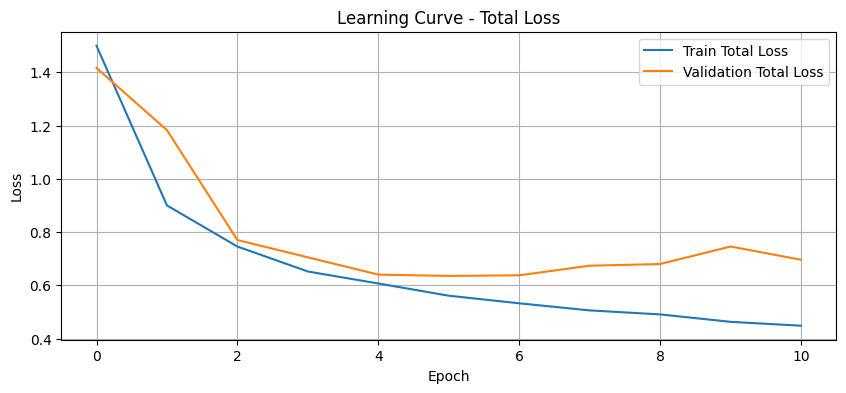

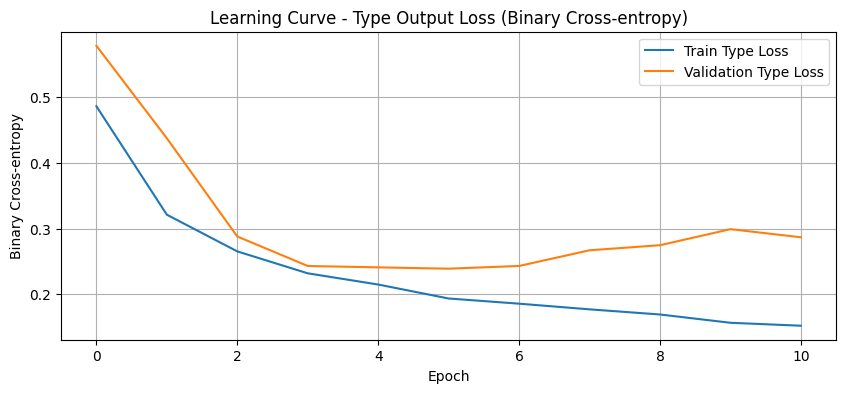

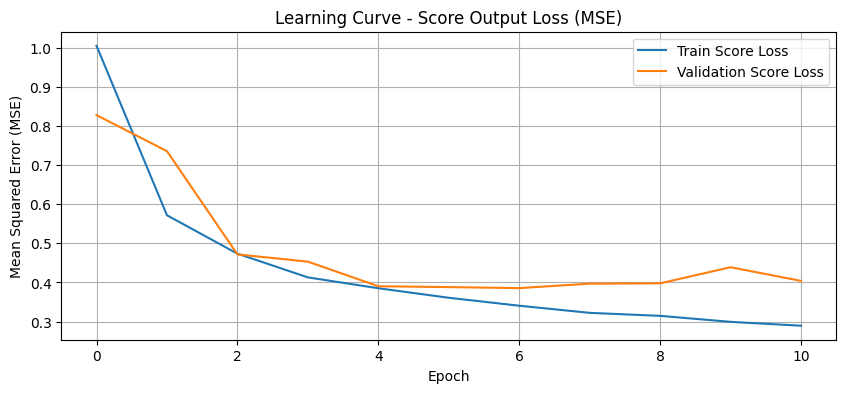

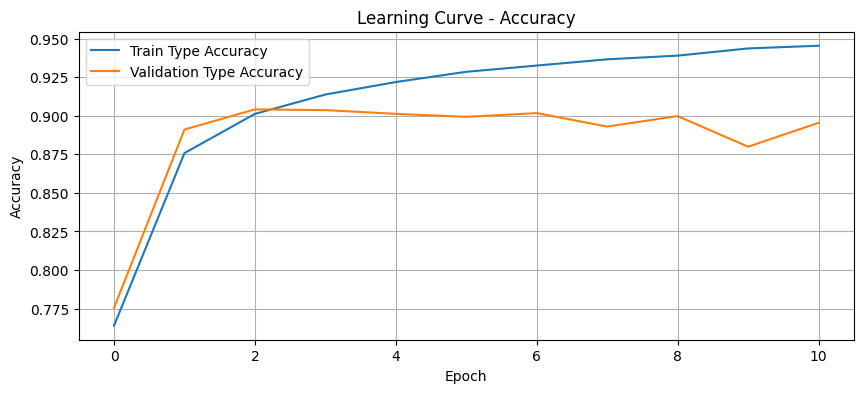

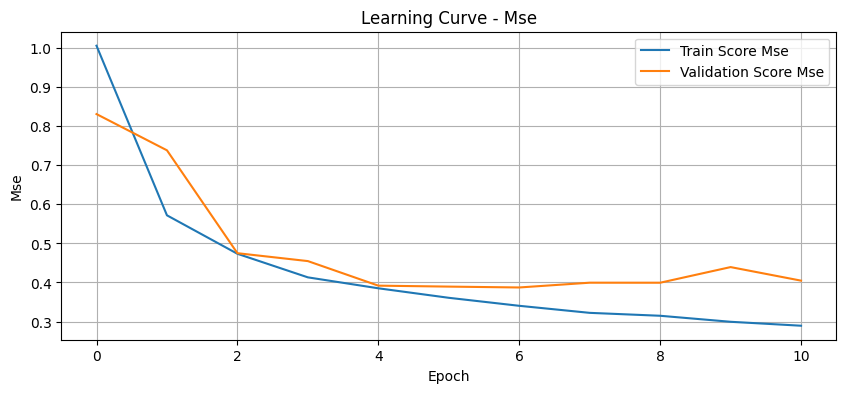

In [ ]:
def plot_learning_curves(history, metrics=None):
    """Plot loss and (optionally) specified metrics for training and validation."""
    # Plot Total Loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Total Loss')
    plt.plot(history.history.get('val_loss', []), label='Validation Total Loss')
    plt.title('Learning Curve - Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Type Output Loss
    if 'type_output_loss' in history.history:
        plt.figure(figsize=(10, 4))
        plt.plot(history.history['type_output_loss'], label='Train Type Loss')
        plt.plot(history.history.get('val_type_output_loss', []), label='Validation Type Loss')
        plt.title('Learning Curve - Type Output Loss (Binary Cross-entropy)')
        plt.xlabel('Epoch')
        plt.ylabel('Binary Cross-entropy')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot Score Output Loss
    if 'score_output_loss' in history.history:
        plt.figure(figsize=(10, 4))
        plt.plot(history.history['score_output_loss'], label='Train Score Loss')
        plt.plot(history.history.get('val_score_output_loss', []), label='Validation Score Loss')
        plt.title('Learning Curve - Score Output Loss (MSE)')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Squared Error (MSE)')
        plt.legend()
        plt.grid(True)
        plt.show()


    # Plot metrics if provided
    if metrics:
        for metric in metrics:
            # Check if the metric exists for either output or globally
            if metric in history.history or f'type_output_{metric}' in history.history or f'score_output_{metric}' in history.history:
                plt.figure(figsize=(10, 4))

                # Plot training metric
                if metric in history.history:
                    plt.plot(history.history[metric], label=f'Train {metric.capitalize()}')
                elif f'type_output_{metric}' in history.history:
                     plt.plot(history.history[f'type_output_{metric}'], label=f'Train Type {metric.capitalize()}')
                elif f'score_output_{metric}' in history.history:
                     plt.plot(history.history[f'score_output_{metric}'], label=f'Train Score {metric.capitalize()}')


                # Plot validation metric
                if f'val_{metric}' in history.history:
                    plt.plot(history.history.get(f'val_{metric}', []), label=f'Validation {metric.capitalize()}')
                elif f'val_type_output_{metric}' in history.history:
                     plt.plot(history.history.get(f'val_type_output_{metric}', []), label=f'Validation Type {metric.capitalize()}')
                elif f'val_score_output_{metric}' in history.history:
                     plt.plot(history.history.get(f'val_score_output_{metric}', []), label=f'Validation Score {metric.capitalize()}')


                plt.title(f'Learning Curve - {metric.capitalize()}')
                plt.xlabel('Epoch')
                plt.ylabel(metric.capitalize())
                plt.legend()
                plt.grid(True)
                plt.show()


plot_learning_curves(final_history, metrics=['accuracy', 'mse'])

## Learning Curves Analysis (with hyperparameters: {'lstm_units': 16, 'dense_units': 8, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'batch_size': 64, 'embedding_dim': 30} )

The following plots summarize the evolution of the training and validation metrics during model training for both outputs:

- **Total Loss**: The overall loss (sum of the two branches) consistently decreases over the epochs for both training and validation sets, indicating that the model is learning meaningful patterns and that there are no major issues with model convergence.

- **Type Output Loss (Binary Cross-Entropy)**: The binary cross-entropy loss for the 'review type' classification output decreases for both training and validation sets, then stabilizes. The validation loss remains close to the training loss, suggesting that the model is not overfitting and generalizes well to unseen data.

- **Score Output Loss (MSE)**: The mean squared error for the 'review score' regression output follows a similar decreasing trend, both for training and validation. The gap between train and validation loss is small, indicating that the model is not underfitting nor overfitting.

- **Accuracy**: The accuracy for the 'review type' classification increases and remains high (>0.9) for both training and validation, with only a small difference between them. This demonstrates robust performance in correctly identifying the review type.

#### **Takeaways**
- **No Overfitting Detected**: The training and validation losses and metrics evolve in parallel and do not diverge, indicating that the model is neither memorizing the training data nor struggling to learn.
- **Stable Generalization**: The model's ability to generalize to unseen data is confirmed by the validation curves, which flatten or slightly increase only at the end—an expected behavior due to early stopping.
- **Good Performance**: High accuracy and low losses suggest that the architecture and regularization choices are appropriate for the task.

If needed, further fine-tuning and experimentation (e.g., wider hyperparameter grid, more epochs) could be performed for even better performance.

---


### SUMMARY OF FINAL MODEL RESULTS

In [ ]:
# Predict on test set
y_pred_type, y_pred_score = final_model.predict([X_text_test, X_struct_test])

# Binarize the type output (threshold = 0.5)
y_pred_type_bin = (y_pred_type > 0.5).astype(int)

print("=== Final Evaluation on Test Set ===")
results = final_model.evaluate([X_text_test, X_struct_test], {'type_output': y_type_test, 'score_output': y_score_test}, verbose=0)
print(f"Total Test Loss: {results[0]:.4f}")
print(f"Test Review Type Loss (Binary crossentropy): {results[1]:.4f}")
print(f"Test Review Type Accuracy: {results[4]:.4f}")
print(f"Test Review Score Loss (MSE): {results[2]:.4f}")
mse = ((y_score_test - y_pred_score.flatten()) ** 2).mean()
print(f"Review Score - Mean Squared Error (MSE): {mse:.4f}")
print("Results:", results)




# --- Confusion Matrix ---
cm = confusion_matrix(y_type_test, y_pred_type_bin)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Bad Review", "Good Review"], yticklabels=["Bad Review", "Good Review"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Review Type)")
plt.show()

print("Precision:", precision_score(y_type_test, y_pred_type_bin))
print("Recall:", recall_score(y_type_test, y_pred_type_bin))
print("F1 Score:", f1_score(y_type_test, y_pred_type_bin))


